# HDR encoding standards

There are many, many of them. 
* RGBE (or Radiance HDR) (32bits) tries to cover to wide dynamic range (76 orders of magnitudes!), resulting in relatively large step size (1%) 
* XYZE iterates on RGBE, similar in dynamic range and step size, but better. 
* LogLuv 32 (32 bits) is a reasonable format. overs 38 orders  of magnitudes at 0.3% step size.
* EXT (48 bits) is expensive, but boasts top of the line performance. (covers 10.7 mag at 0.1% step size)


Maybe it's not too important because I will anyways use astronomical .fits files.  
That also means that I will have to **re-define the luminance** in astronomical images. 

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 

In [82]:
import imageio

In [87]:
imageio.plugins.freeimage.download()

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%237568/4830080 bytes (4.9%745472/4830080 bytes (15.41294336/4830080 bytes (26.8%2056192/4830080 bytes (42.6%2908160/4830080 bytes (60.2%3973120/4830080 bytes (82.3%4830080/4830080 bytes (100.0%)
  Done
File saved as /home/hoseung/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [94]:
img = imageio.imread("../../bf_data/memorial.exr")#, format='hdr-fi')

In [62]:
fn = 'Mantiuk'
tmo = cv.createTonemap(2.2)
mapped = tmo.process(img)
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite(fn+".png", im2_8bit)


#plt.imshow(mapped)

True

In [92]:
img.shape

(768, 512)

# Luminance, lightness and brightness

## Lightness
Lightness is the **Perceptual** dimension that runs from black, through gray to white. 
This is the **perceived** reflectance. That is, different from the genuine reflectance of the material.  
For example, 'black' material in sunlit can reflect more light than 'white' material under shadow. Still we call the former *black* and the later *white*.  
Lightness depends strongly on the *context*. 


## Brightness = percieved luminance
Brightness is, again, the **perceptual** dimension that runs from dim to bright. 
This is the **perceived** ***luminance***, where luminance means the *intensity* of light coming from an object.  (the SI unit for luminance is cd/m$^2$)  
Note that the *reflectance* is an inherit property of a material, whereas the *luminance* depends on the intensity of light coming to the material, and so on and so forth. 


## luminance from RGB colors
### sRGB gamma encoding 
linear combination of R,G and B components (color primaries) in sRGB color space results in non-linear brightness curve. **Gamma encoding** is applied to combinations of color primaries so that perceived brightness level is as smooth as possible for the given number of discrete colors. 
In other words, gamma encoding (others call 'correction') makes difference between brightness 5 to 6 feel similar to 250 to 251. (see also, https://stackoverflow.com/a/56678483/4294919)

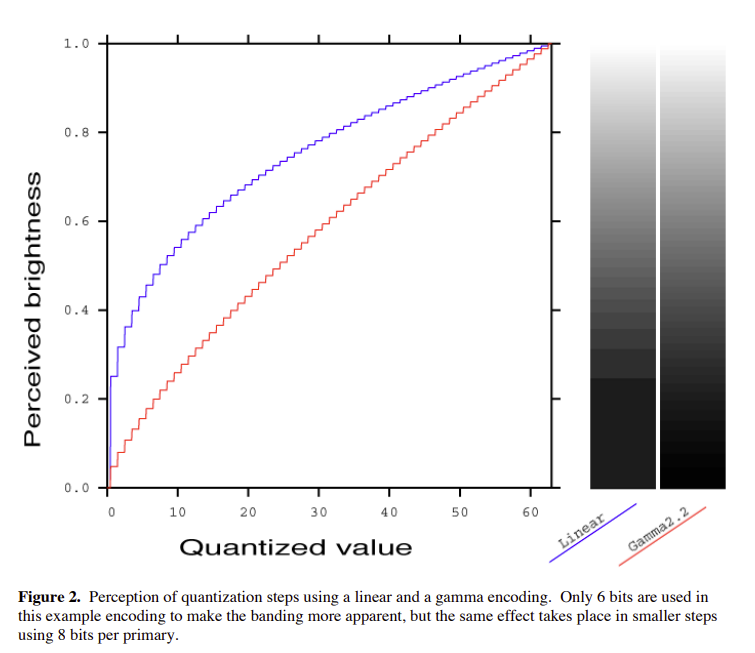
(image from http://www.anyhere.com/gward/hdrenc/hdr_encodings.html)

#### [CIE XYZ](https://en.wikipedia.org/wiki/CIE_1931_color_space#Meaning_of_X,_Y_and_Z) color space
Roughly speaking, CIE XYZ is designed to mimic the way human visual receptors function. Y is equivalent with **luminance**, Z is quasi-equal to blue, or the S cone response, and X is a mix of response curves. An XZ plane at any Y contains *all possible* chromaticities at the luminance Y. CIE XYZ color space is device-invariant, and serves as a standard reference against which other color spaces are defined.   
Since we are concerned about luminance, **CIE Y** value is also important in tone mapping. 

#### Transformation from sRGB to CIE XYZ

,
where linear R(,G,B) is inverse_gamma_correct(R) 

In [180]:
def inv_gamma(color):
    """
    Inverse of sRGB gamma encoding. 
    The gamma curve is often dubbed as power of 2.2 curve,
    but the exact form (to avoid numerical error at the lower end) is linear + power or 2.4.
    """
    conditions=[color <= 0.04045,
                color > 0.04045]
    functions=[lambda color: color/12.92,
              lambda color: ((color+0.055)/1.055)**2.4]
    return np.piecewisec(color, conditions, functions)

def rgb_to_CIEXYZ(rgb):
    transform = np.array([[0.41239080, 0.35758434, 0.18048079],
                          [0.21263901, 0.71516868, 0.07219232],
                          [0.01933082, 0.11919478, 0.95053215]])
    return np.matmul(np.asarray(rgb), transform.T)

In [170]:
def YtoLstar(Y):
    """
    Send this function a luminance value between 0.0 and 1.0,
    and it returns L* which is "perceptual lightness"
    """
    if ( Y <= (216/24389) #       // The CIE standard states 0.008856 but 216/24389 is the intent for 0.008856451679036
        return Y * (24389/27)#  // The CIE standard states 903.3, but 24389/27 is the intent, making 903.296296296296296
    else 
        return Y**(1/3) * 116 - 16
        
(cX, cY, cZ) = rgb_to_CIEXYZ([1,1,1])
print(f"(1,1,1)_rgb is white, or {cY} in CIE Y value.")

SyntaxError: invalid syntax (<ipython-input-170-b0ecb738d218>, line 26)

In [45]:
def simple_reinhard(img):
    return img / (1+img)

mapped = simple_reinhard(img)
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite("simpleReinhard.png", im2_8bit)

True

(789, 2048, 3)


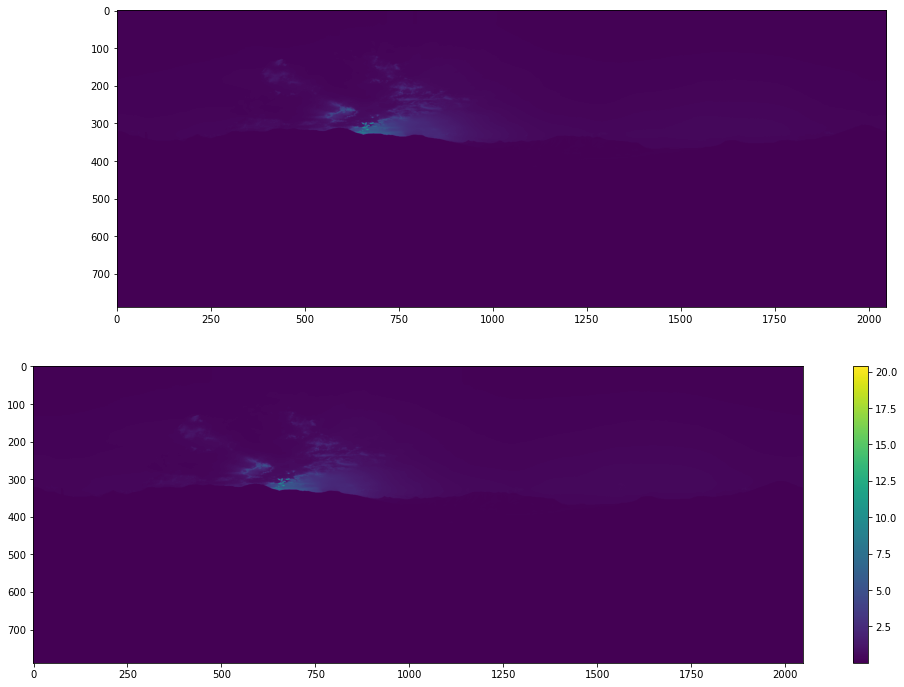

In [70]:
CIE_XYZ = rgb_to_CIEXYZ(img) # No, it's not in RGB to begin with!

print(CIE_XYZ.shape)
# Luminance map
luminance = CIE_XYZ[:,:,1]
fig, axs = plt.subplots(2)
fig.set_size_inches(18,12)
axs[0].set_aspect("equal")
axs[0].imshow(img[:,:,1])
im = axs[1].imshow(luminance)
plt.colorbar(im)
plt.show()

In [199]:
def change_luminance(rgb, l_out):
    l_in = rgb_to_CIEXYZ(rgb)[:,:,1]
    print(np.max(rgb, axis=(0,1)))
    multiplier = np.expand_dims(l_out/l_in, -1)
    print(multiplier.shape)
    print(np.max(multiplier, axis=(0,1)))
    return rgb * multiplier
    #return rgb * (l_out/np.expand_dims(l_in, -1))

def reinhard_extended(img):
    """
    Any pixel above the 'white point' will be saturated.
    """
    #white = np.max(img) #-15
    #white =
    print(np.max(img, axis=(0,1)))
    l_old = rgb_to_CIEXYZ(img)[:,:,1]
    white = np.max(l_old)
    l_new = l_old * (1+(l_old/white**2)) / (1+l_old)
    print(np.max(l_new, axis=(0,1)))
    return change_luminance(img, l_new)

mapped = reinhard_extended(img)
#mapped[:,:,1],mapped[:,:,2] = mapped[:,:,2],mapped[:,:,1].copy()
print(np.max(mapped, axis=(0,1)))
im2_8bit = np.clip(mapped * 255, 0, 255).astype('uint8')
cv.imwrite("Reinhard_extended.png", im2_8bit)

[275.  219.  126.5]
1.0
[275.  219.  126.5]
(768, 512, 1)
[0.99934585]
[2.95821729 1.57328977 1.66504103]


True

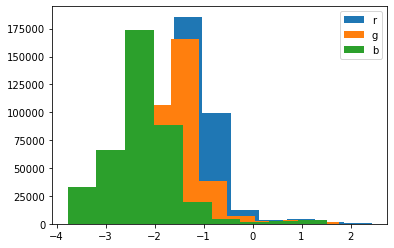

In [169]:
plt.hist(np.log10(img[:,:,0].ravel()), label='r')#, histtype="step")
plt.hist(np.log10(img[:,:,1].ravel()), label='g')#, histtype="step")
plt.hist(np.log10(img[:,:,2].ravel()), label='b')#, histtype="step")
plt.legend()
plt.show()

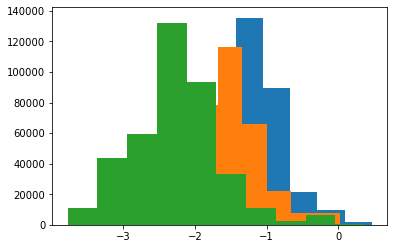

In [166]:
plt.hist(np.log10(mapped[:,:,0].ravel()))
plt.hist(np.log10(mapped[:,:,1].ravel()))
plt.hist(np.log10(mapped[:,:,2].ravel()))
plt.show()

In [122]:
 # Why blue channel is as strong as others? it was around the half of others originally...


array([1.       , 0.9983372, 0.9938165], dtype=float32)

In [ ]:
mapped